## Latar Belakang

Tipe kepribadian Myers-Briggs Type Indicator (MBTI) menjadi salah satu alat psikometri yang paling populer pada masa ini. MBTI digunakan dalam berbagai bidang, seperti konseling dan rekrutmen pekerja. Namun, pengukuran MBTI biasanya masih dilakukan manual dengan kuesioner dan berdasarkan kesadaran diri responden sehingga kurang efisien dan hasil pengukuran tidak selalu mencerminkan perilaku nyata responden.

Natural Language Processing (NLP) adalah bidang Artificial Intelligence (AI) yang berfokus pada bahasa manusia. Dengan NLP, ada kemungkinan menganalisis MBTI orang dari pola bahasa yang digunakan. Beberapa penelitian menunjukkan bahwa orang dengan MBTI sama memiliki gaya tulisan yang sama pada media sosial. NLP dapat mengenali kata dan kalimat penting yang bisa mengenali karakter user.

https://www.sciencedirect.com/science/article/abs/pii/S0957417425029100 (penelitian yang dimaksud)

## Data

Dataset yang digunakan adalah  Myers-Briggs Personality Type Dataset, yang diperoleh dari kaggle (https://www.kaggle.com/datasets/datasnaek/mbti-type).

Dataset ini terdiri dari 8.675 baru data dengan dua kolom utama:

1. type (Label) : Kode 4 huruf yang merepresentasikan tipe kepribadian (misal: INFJ, ENTP) ini adalah target yang akan kita prediksi

2. posts (Fitur/Input): Kumpulan 50 postingan terakhir yang dibuat oleh pengguna tersebut.

Pada kolom post, setiap sel data tidak hanya berisi satu kalimat tetapi berisi gabungan dari 50 postingan berbeda yang dipisahkan dengan delimiter (pemisah) berupa tiga garis vertikal (| | |).
Karena input teks ini sangat panjang, model tidak dapat memprosesnya sekaligus, sehingga kita perlu melakukan strategi preprocessing, seperti memisahkan postingan berdasarkan delimiter tersebut atau memotong teks agar sesuai dengan batas token maksimal BERT (512 token). Selain itu data ini masih mengandung noise berupa URL dan karakter khusus yang perlu dibersihkan.



### 1. Data Preparation

In [ ]:
!gdown 1SSTov2eQ5prglN-Dz7KHDpKIQkpV2l8f # unduh file mbti_1.csv kedalam folder
!pip install clean-text

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import torch
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from sklearn.utils.class_weight import compute_class_weight
from torch.nn import CrossEntropyLoss
from scipy.stats import mannwhitneyu

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from cleantext import clean


In [3]:
# Load Data
df = pd.read_csv('mbti_1.csv')
df.head(5)

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [4]:
df['posts'] = df['posts'].apply(lambda x: clean(x,
    no_urls=True,
    replace_with_url="",
    lower=True
))

print(df['posts'].head())

0    ' and intj moments sportscenter not top ten pl...
1    'i'm finding the lack of me in these posts ver...
2    'good one _____ course, to which i say i know;...
3    'dear intp, i enjoyed our conversation the oth...
4    'you're fired.|||that's another silly misconce...
Name: posts, dtype: object


/tmp/ipython-input-933076193.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=type_counts.index, y=type_counts.values, palette="viridis")


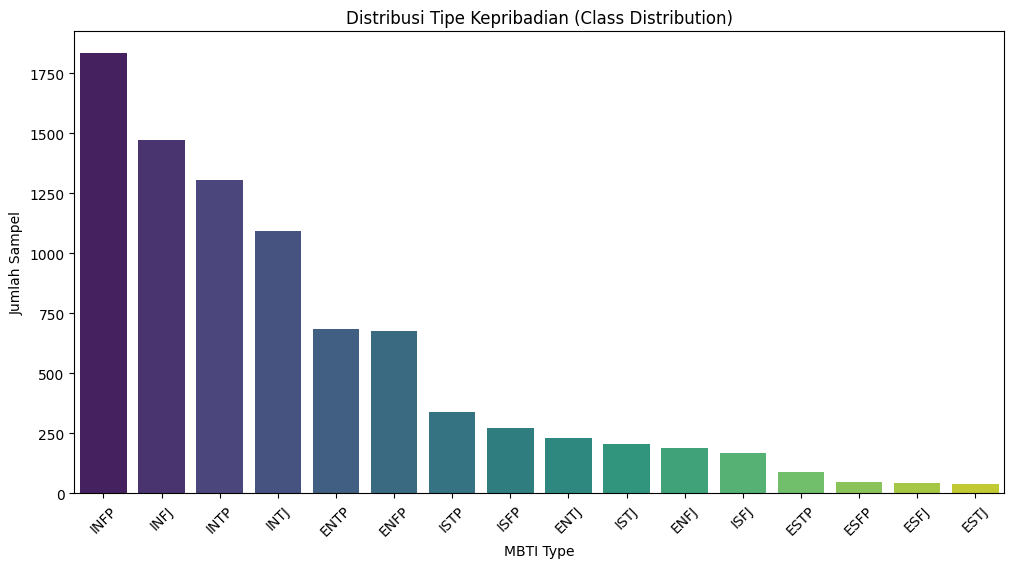

Tipe Terbanyak: INFP ( 1832 sampel)
Tipe Tersedikit: ESTJ ( 39 sampel)


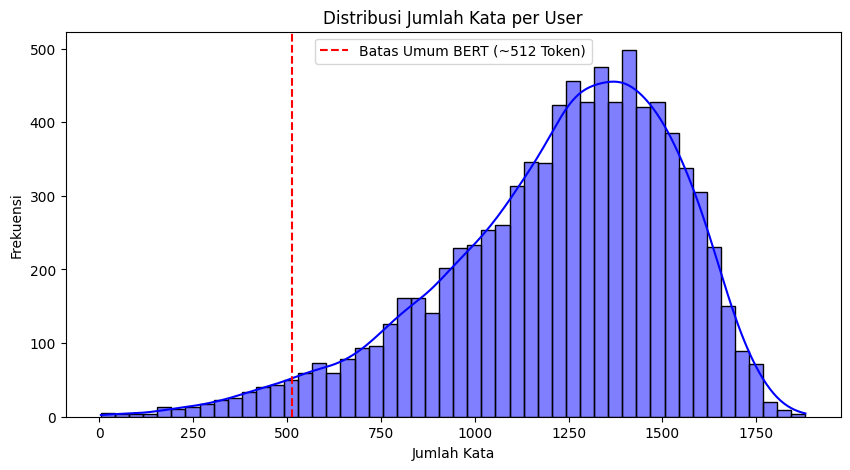


Statistik Panjang Kata:
count    8675.000000
mean     1224.663862
std       312.046343
min         4.000000
25%      1045.000000
50%      1276.000000
75%      1456.000000
max      1881.000000
Name: word_count, dtype: float64


In [5]:
# Hitung jumlah setiap tipe
type_counts = df['type'].value_counts()

# Visualisasi Bar Chart
plt.figure(figsize=(12, 6))
sns.barplot(x=type_counts.index, y=type_counts.values, palette="viridis")
plt.title('Distribusi Tipe Kepribadian (Class Distribution)')
plt.xlabel('MBTI Type')
plt.ylabel('Jumlah Sampel')
plt.xticks(rotation=45)
plt.show()

# Print rasio ketidakseimbangan
print("Tipe Terbanyak:", type_counts.idxmax(), "(", type_counts.max(), "sampel)")
print("Tipe Tersedikit:", type_counts.idxmin(), "(", type_counts.min(), "sampel)")

# Menghitung jumlah kata per baris data
# (Kita split berdasarkan spasi untuk estimasi kasar jumlah kata)
df['word_count'] = df['posts'].apply(lambda x: len(x.split()))

# Visualisasi Histogram Panjang Kata
plt.figure(figsize=(10, 5))
sns.histplot(df['word_count'], bins=50, kde=True, color='blue')
plt.title('Distribusi Jumlah Kata per User')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
# Menambahkan garis batas token BERT (Estimasi: 1 token ~= 0.75 kata, jadi 512 token ~= 380 kata)
plt.axvline(x=512, color='red', linestyle='--', label='Batas Umum BERT (~512 Token)')
plt.legend()
plt.show()

# Statistik Deskriptif Panjang Kata
print("\nStatistik Panjang Kata:")
print(df['word_count'].describe())

Berdasarkan visualisasi data, ditemukan tantangan fundamental berupa ketidakseimbangan kelas (class imbalance) yang signifikan. Dataset ini didominasi oleh tipe kepribadian dengan dimensi Introvert (I) dan Intuitive (N)—khususnya kelas INFP, INFJ, INTP, dan INTJ yang menempati proporsi terbesar. Sebaliknya, tipe kepribadian dengan dimensi Extrovert (E) dan Sensing (S), seperti ESTJ dan ESFJ, memiliki jumlah sampel yang sangat minim (kelas minoritas).

Kondisi ini berpotensi menyebabkan model menjadi bias, di mana model akan cenderung memprediksi kelas mayoritas (INxx) dan gagal mengenali pola pada kelas minoritas. Oleh karena itu, metrik evaluasi yang digunakan nantinya tidak cukup hanya mengandalkan Accuracy, melainkan harus memperhatikan F1-Score atau Confusion Matrix untuk memastikan model belajar secara adil pada semua kelas.


In [6]:
# Encoding: mengubah setiap teks kategori di kolom type menjadi angka 0-15
label_encoder = LabelEncoder()                          # Membuat instance dari kelas LabelEncoder()
df['label'] = label_encoder.fit_transform(df['type'])   # Fit dan Transform kolom type dengan label_encoder
print(label_encoder.classes_)

['ENFJ' 'ENFP' 'ENTJ' 'ENTP' 'ESFJ' 'ESFP' 'ESTJ' 'ESTP' 'INFJ' 'INFP'
 'INTJ' 'INTP' 'ISFJ' 'ISFP' 'ISTJ' 'ISTP']


In [7]:
# Membagi data menjadi data train dan data validasi
train_df, val_df = train_test_split(df, test_size=0.2, random_state=2674)

## Algoritma

### BERT *(Bidirectional Encoder Representations from Transformers)*

BERT adalah model bidirectional Transformer encoder yang dilatih untuk memahami konteks bahasa. Oleh karena BERT menggunakan encoder-only, BERT sangat kuat dalam klasifikasi teks, klastering, semantic retrieval, dan analisis makna konteks.
<br>
<br>

**Komponen Utama pada BERT**:
![gambar](https://drive.google.com/uc?id=1gkFCeY5wRbSr4aVu4YlNlFYfCKIK1l9U)
1. <u>Word Embedding:</u>
    - Setiap token diubah menjadi vektor angka melalui:
        - Token Embedding
        - Positional Embedding
        - Segment Embedding
    - Embedding yang baik membuat kata dengan makna mirip memiliki representasi vektor yang mirip

2. <u>Positional Encoding</u>
    - Memberikan informasi urutan kata di
    - BERT menggunakan learned positional embeddings
    - Dibutuhkan karena makna kalimat berbeda jika urutan berubah

3. <u>Multi-Head Attention (Bidirectional Attention)</u>
    - Setiap kata melihat semua kata lain di kiri dan kanan
    - Memungkinkan pemahaman konteks penuh dan hubungan antar kata

4. <u>Feed-Forward Network</u>
    - Metode Self-Supervised Learning
    - Melakukan proses Pre-Training BERT
    - Melalui beberapa tahap:
      - Forward Pass
      - Menghitung Loss
      - Backpropagation
      - Optimizer (Update)
<br>

**Pre-Training BERT**:

1. <u>Masked Language Modeling (MLM)</u>
![gambar](https://drive.google.com/uc?id=1N3pvZ09ApWP2K5--NpFwX8IdJMZDQdmQ)
    - Beberapa token diacak dan diganti dengan [MASK]
    - Model menebak token yang hilang
    - Melatih BERT memahami konteks kiri dan kanan secara bersamaan (dua arah)
2. <u>Next Sentence Prediction (NSP)</u>
![gambar](https://drive.google.com/uc?id=1XRqNPOfHJKfKHNsIHk8J9OPzcFQGq73I)
    - Memprediksi apakah kalimat B nyambung dengan kalimat A
    - Membantu BERT memahami hubungan antar kalimat
<br>

**Fine-Tuning BERT**:
1. Output layer BERT diganti dengan layer baru mengklasifikasi MBTI
2. BERT melalui Supervised Learning menggunakan dataset MBTI
<br>

**BERT Cocok untuk Klasifikasi MBTI karena**:
1. <u>Pre-trained Model</u>
    
    BERT telah dilatih sebelumnya pada sejumlah besar data teks dan dapat menangkap konteks secara efektif untuk memahami nuansa dalam deskripsi tekstual atau postingan yang berkaitan dengan ciri-ciri kepribadian seseorang.

2. <u>Kemampuan Fine-Tuning</u>:

    BertForSequenceClassification memungkinkan kita untuk melakukan fine-tuning model pada dataset spesifik dan mempelajari pola-pola khusus untuk tugas klasifikasi MBTI.

3. <u>Klasifikasi Multi-Kelas</u>:

    Terdapat 16 kemungkinan tipe MBTI dan arsitektur BERT dapat menangani klasifikasi multi-kelas secara efektif dan memungkinkan kita untuk mengklasifikasikan input ke dalam salah satu dari 16 tipe MBTI.


### RoBERTa *(Robustly Optimized BERT Pretraining Approach)*

Model Pembanding yang digunakan dalam proyek ini adalah RoBERTa. Perbedaan BERT dengan RoBERTa dapat dilihat melalui tabel di bawah ini:

| Aspek                     | BERT                                   | RoBERTa                                      |
|--------------------------|----------------------------------------|----------------------------------------------|
| Arsitektur dasar         | Transformer Encoder                    | Transformer Encoder (sama seperti BERT)      |
| Jumlah layer             | Sama (Base: 12, Large: 24)             | Sama (Base: 12, Large: 24)                   |
| Hidden size              | Sama (Base: 768, Large: 1024)          | Sama                                         |
| Self-Attention           | Multi-Head Self-Attention              | Multi-Head Self-Attention                    |
| Positional Embedding     | Learned positional embedding           | Learned positional embedding                 |
| Pretraining objective    | MLM + NSP                              | MLM saja (NSP dihapus)                       |
| Masking strategy         | Static masking                         | Dynamic masking                              |
| Next Sentence Prediction | Digunakan                              | Tidak digunakan                              |
| Data pelatihan           | Wikipedia + BookCorpus (~3B kata)      | Dataset lebih besar (~160GB teks)            |
| Batch size               | Relatif lebih kecil                    | Jauh lebih besar                             |
| Training steps           | Lebih sedikit                          | Lebih banyak                                 |
| Optimasi training        | Standar                               | Lebih agresif & teroptimasi                  |
| Performa downstream task | Baik                                   | Umumnya lebih baik dari BERT                 |
| Kebutuhan komputasi      | Lebih ringan                           | Lebih berat                                  |

### 2. Tokenization

![gambar](https://drive.google.com/uc?id=1N-F64UrQmcGHSLeZaHa35cDCDMQI5VtV)

In [8]:
# Memuat tokenizer BERT yang sudah dilatih sebelumnya, yaitu 'bert-base-uncased'
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer_roberta = RobertaTokenizer.from_pretrained('roberta-base')

# Melakukan tokenisasi
train_encodings_bert = tokenizer_bert(train_df['posts'].tolist(), padding=True, truncation=True, max_length=512)
val_encodings_bert = tokenizer_bert(val_df['posts'].tolist(), padding=True, truncation=True, max_length=512)
train_encodings_roberta = tokenizer_roberta(train_df['posts'].tolist(), padding=True, truncation=True, max_length=512)
val_encodings_roberta = tokenizer_roberta(val_df['posts'].tolist(), padding=True, truncation=True, max_length=512)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


**Keterangan:**


*   posts adalah kumpulan teksnya
*   padding memastikan agar panjang input sama pada setiap batch
*   truncation memotong teks yang panjangnya lebih
*   max_length yang sesuai dengan batas maksimal input BERT
*   Output dictionary 'input_ids' dan 'attention_mask'.
*   input_ids berisi hasil tokenisasi dan attention_mask menunjukkan nilai 0 yang padding dan nilai 1 yang tidak padding




In [9]:
# Membuat Class MBTIDataset agar data bisa dimasukkan ke model BERT baris demi baris secara efisien.
class MBTIDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [10]:
# Create dataset objects
train_dataset_bert = MBTIDataset(train_encodings_bert, train_df['label'].tolist())
val_dataset_bert = MBTIDataset(val_encodings_bert, val_df['label'].tolist())
train_dataset_roberta = MBTIDataset(train_encodings_roberta, train_df['label'].tolist())
val_dataset_roberta = MBTIDataset(val_encodings_roberta, val_df['label'].tolist())

### 3. Model Setup

In [11]:
def compute_metrics(p):
    predictions, labels = p
    preds = np.argmax(predictions, axis=1)

    return {
        "accuracy": accuracy_score(labels, preds),

        # Macro → semua kelas MBTI dianggap sama penting
        "precision_macro": precision_score(labels, preds, average="macro", zero_division=0),
        "recall_macro": recall_score(labels, preds, average="macro", zero_division=0),
        "f1_macro": f1_score(labels, preds, average="macro", zero_division=0),

        # Weighted → mempertimbangkan distribusi data
        "precision_weighted": precision_score(labels, preds, average="weighted", zero_division=0),
        "recall_weighted": recall_score(labels, preds, average="weighted", zero_division=0),
        "f1_weighted": f1_score(labels, preds, average="weighted", zero_division=0),
    }

**Keterangan:**

- `p` adalah tuple dengan isi:  
  `p = EvalPrediction(predictions=predictions, label_ids=labels)`

- `predictions` adalah *list of lists* yang berisi nilai **logits prediksi MBTI**  
  untuk setiap orang (masing-masing 16 kelas MBTI).

Contoh struktur `predictions`:

```text
predictions = [
    [ 2.1,  0.5,  ...,  1.2 ],   # Orang 1 → 16 logits MBTI
    [ 1.0,  3.2,  ...,  0.7 ],   # Orang 2 → 16 logits MBTI
    [ 0.2, -0.5,  ...,  2.0 ]    # Orang 3 → 16 logits MBTI
]

labels = [
    "INFP",
    "ENTJ",
    "ISFJ"
]
```



In [12]:
class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = torch.tensor(class_weights, dtype=torch.float).to(self.model.device)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # Ambil labels
        labels = inputs["labels"].to(model.device)

        # Forward Pass
        outputs = model(**inputs)
        logits = outputs.logits if hasattr(outputs, "logits") else outputs[0]

        # CrossEntropyLoss dengan class_weights
        loss_fct = CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))

        return (loss, outputs) if return_outputs else loss


**Keterangan:**

Class weight adalah bobot untuk tiap kelas dalam dataset yang digunakan saat training model untuk memberik perhatian yang lebih pada kelas minoritas agar model tidak bias pada kelas mayoritas.

Class weight bekerja dengan menghukum kesalahan kelas minoritas lebih besar dari mayoritas sehingga lebih adil ke semua kelas.

In [13]:
# Memuat model BERT yang sebelumnya sudah dilatih untuk klasifikasi
# dengan num_labels adalah jumlah kelas (16 untuk kasus MBTI)
# BertForSequenceClassification adalah varian BERT yang menambahkan classification head (fully connected layer) di atas token [CLS]
# Sehingga cocok untuk klasifikasi
model_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))
model_roberta = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(label_encoder.classes_))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# Memindahkan model ke GPU jika ada, jika tidak gunakan CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bert.to(device)
model_roberta.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

### 4. Training

**Mengatur Konfigurasi Pelatihan**

- `output_dir`: Direktori untuk menyimpan hasil checkpoint model.  
- `num_train_epochs`: Model dilatih selama 3 kali melewati seluruh dataset.  
- `batch_size`: Tiap step training dan evaluasi memproses 8 sampel.  
- `learning_rate`: Menetapkan kecepatan belajar yang stabil untuk fine-tuning BERT.  
- `warmup_steps`: Pada 500 langkah pertama, learning rate naik perlahan untuk menghindari training tidak stabil di awal.  
- `weight_decay`: Regularisasi untuk mencegah overfitting.  
- `logging_steps`: Mencatat perkembangan loss setiap 10 langkah.  
- `eval_strategy` & `save_strategy`: Melakukan evaluasi dan menyimpan checkpoint model setiap selesai 1 epoch.  
- `load_best_model_at_end`: Secara otomatis memuat versi model terbaik (berdasarkan akurasi tertinggi) setelah seluruh proses selesai.  
- `metric_for_best_model`: Menetapkan indikator utama keberhasilan model, dalam hal ini **akurasi**.  
- `report_to`: Mematikan pelaporan ke WandB atau TensorBoard.


In [15]:
# Mengatur Konfigurasi Pelatihan
training_args_bert = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to='none',
    metric_for_best_model='eval_f1_weighted'
)

training_args_roberta = TrainingArguments(
    output_dir='./results_roberta',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-5,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_roberta',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to='none',
    metric_for_best_model='eval_f1_weighted'
)

In [16]:
# Class weight untuk BERT
labels_train_bert = [label.item() if isinstance(label, torch.Tensor) else label
                     for label in train_dataset_bert.labels]
labels_train_bert = np.array(labels_train_bert)

class_weights_bert = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels_train_bert),
    y=labels_train_bert
)
class_weights_bert = torch.tensor(class_weights_bert, dtype=torch.float)

# Class weight untuk RoBERTa
labels_train_roberta = [label.item() if isinstance(label, torch.Tensor) else label
                        for label in train_dataset_roberta.labels]
labels_train_roberta = np.array(labels_train_roberta)
class_weights_roberta = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels_train_roberta),
    y=labels_train_roberta
)
class_weights_roberta = torch.tensor(class_weights_roberta, dtype=torch.float)

In [17]:
trainer_bert = WeightedTrainer(
    model=model_bert,
    args=training_args_bert,
    train_dataset=train_dataset_bert,
    eval_dataset=val_dataset_bert,
    compute_metrics=compute_metrics,
    class_weights=class_weights_bert
)

trainer_roberta = WeightedTrainer(
    model=model_roberta,
    args=training_args_roberta,
    train_dataset=train_dataset_roberta,
    eval_dataset=val_dataset_roberta,
    compute_metrics=compute_metrics,
    class_weights=class_weights_roberta
)

/tmp/ipython-input-4065710024.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(class_weights, dtype=torch.float).to(self.model.device)


In [21]:
trainer_bert.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,1.403200,1.786131,0.582709,0.496297,0.492256,0.479554,0.611322,0.582709,0.588987
2,1.036100,1.842847,0.587320,0.539802,0.497248,0.510559,0.590602,0.587320,0.587224
3,0.785200,1.914601,0.605187,0.573938,0.504319,0.527335,0.607446,0.605187,0.603406


TrainOutput(global_step=2604, training_loss=1.1238029304371084, metrics={'train_runtime': 2212.7301, 'train_samples_per_second': 9.409, 'train_steps_per_second': 1.177, 'total_flos': 5478660755619840.0, 'train_loss': 1.1238029304371084, 'epoch': 3.0})

In [23]:
trainer_roberta.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,2.890200,2.724262,0.126801,0.007925,0.062500,0.014066,0.016079,0.126801,0.028538
2,2.669000,2.713400,0.155043,0.009690,0.062500,0.016779,0.024038,0.155043,0.041623
3,2.738400,2.718067,0.126801,0.007925,0.062500,0.014066,0.016079,0.126801,0.028538


TrainOutput(global_step=2604, training_loss=2.742529786676855, metrics={'train_runtime': 2269.7704, 'train_samples_per_second': 9.173, 'train_steps_per_second': 1.147, 'total_flos': 5489186520760320.0, 'train_loss': 2.742529786676855, 'epoch': 3.0})

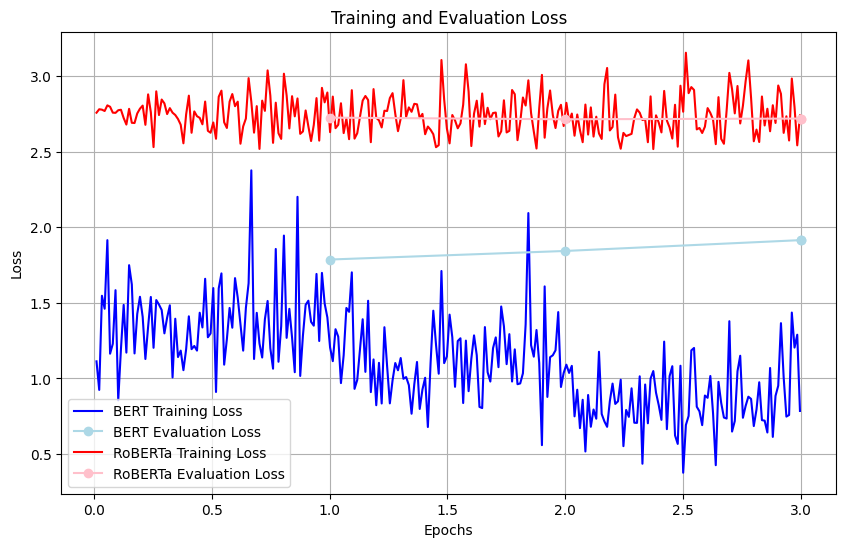

In [25]:
# Mengambil Data Historis
history_bert = trainer_bert.state.log_history
history_roberta = trainer_roberta.state.log_history

# Memfilter Data
train_loss_bert = [log['loss'] for log in history_bert if 'loss' in log]
eval_loss_bert = [log['eval_loss'] for log in history_bert if 'eval_loss' in log]
epochs_bert = [log['epoch'] for log in history_bert if 'loss' in log]
eval_epochs_bert = [log['epoch'] for log in history_bert if 'eval_loss' in log]

train_loss_roberta = [log['loss'] for log in history_roberta if 'loss' in log]
eval_loss_roberta = [log['eval_loss'] for log in history_roberta if 'eval_loss' in log]
epochs_roberta = [log['epoch'] for log in history_roberta if 'loss' in log]
eval_epochs_roberta = [log['epoch'] for log in history_roberta if 'eval_loss' in log]

# Plot Grafik
plt.figure(figsize=(10, 6))
plt.plot(epochs_bert, train_loss_bert, label='BERT Training Loss', color='blue')
plt.plot(eval_epochs_bert, eval_loss_bert, label='BERT Evaluation Loss', color='lightblue', marker='o')
plt.plot(epochs_roberta, train_loss_roberta, label='RoBERTa Training Loss', color='red')
plt.plot(eval_epochs_roberta, eval_loss_roberta, label='RoBERTa Evaluation Loss', color='pink', marker='o')

plt.title('Training and Evaluation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# Save the model
model_bert.save_pretrained('./fine-tuned-model-bert')
tokenizer_bert.save_pretrained('./fine-tuned-model-bert')
model_roberta.save_pretrained('./fine-tuned-model-roberta')
tokenizer_roberta.save_pretrained('./fine-tuned-model-roberta')

('./fine-tuned-model-roberta/tokenizer_config.json',
 './fine-tuned-model-roberta/special_tokens_map.json',
 './fine-tuned-model-roberta/vocab.json',
 './fine-tuned-model-roberta/merges.txt',
 './fine-tuned-model-roberta/added_tokens.json')

## Evaluasi

In [22]:
# Evaluasi BERT
trainer_bert.evaluate()

{'eval_loss': 1.91460120677948,
 'eval_accuracy': 0.6051873198847262,
 'eval_precision_macro': 0.5739377284377567,
 'eval_recall_macro': 0.5043189994491135,
 'eval_f1_macro': 0.5273345897162104,
 'eval_precision_weighted': 0.6074460219261534,
 'eval_recall_weighted': 0.6051873198847262,
 'eval_f1_weighted': 0.6034060103660964,
 'eval_runtime': 49.0152,
 'eval_samples_per_second': 35.397,
 'eval_steps_per_second': 4.427,
 'epoch': 3.0}

In [24]:
# Evaluasi RoBERTa
trainer_roberta.evaluate()

{'eval_loss': 2.71340012550354,
 'eval_accuracy': 0.15504322766570605,
 'eval_precision_macro': 0.009690201729106628,
 'eval_recall_macro': 0.0625,
 'eval_f1_macro': 0.016778942115768462,
 'eval_precision_weighted': 0.024038402444999957,
 'eval_recall_weighted': 0.15504322766570605,
 'eval_f1_weighted': 0.04162338147911669,
 'eval_runtime': 44.0303,
 'eval_samples_per_second': 39.405,
 'eval_steps_per_second': 4.928,
 'epoch': 3.0}

In [30]:
# BERT
# Ambil labels dari custom Dataset
y_true_bert = [label.item() if isinstance(label, torch.Tensor) else label
               for label in val_dataset_bert.labels]
bert_preds_raw = trainer_bert.predict(val_dataset_bert)
y_pred_bert = bert_preds_raw.predictions.argmax(axis=1)

# RoBERTa
y_true_roberta = [label.item() if isinstance(label, torch.Tensor) else label
                  for label in val_dataset_roberta.labels]
roberta_preds_raw = trainer_roberta.predict(val_dataset_roberta)
y_pred_roberta = roberta_preds_raw.predictions.argmax(axis=1)

In [31]:
# F1 SCORE BERT
f1_per_class_bert = f1_score(y_true_bert, y_pred_bert, average=None)
classes_bert = np.unique(y_true_bert)
df_f1_bert = pd.DataFrame({
    "class": classes_bert,
    "f1": f1_per_class_bert
})

# F1 SCORE RoBERTa
f1_per_class_roberta = f1_score(y_true_roberta, y_pred_roberta, average=None)
classes_roberta = np.unique(y_true_roberta)
df_f1_roberta = pd.DataFrame({
    "class": classes_roberta,
    "f1": f1_per_class_roberta
})

In [33]:
# DESCRIPTIVE STATISTICS
print("BERT F1 Descriptive Stats")
print(df_f1_bert["f1"].describe())

print("\nRoBERTa F1 Descriptive Stats")
print(df_f1_roberta["f1"].describe())

BERT F1 Descriptive Stats
count    16.000000
mean      0.527335
std       0.101045
min       0.333333
25%       0.496067
50%       0.542265
75%       0.611008
max       0.652893
Name: f1, dtype: float64

RoBERTa F1 Descriptive Stats
count    16.000000
mean      0.016779
std       0.067116
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       0.268463
Name: f1, dtype: float64


In [34]:
# MANN-WHITNEY U TEST (BERT VS ROBERTA)
f1_bert_sorted = df_f1_bert.sort_values("class")["f1"].values
f1_roberta_sorted = df_f1_roberta.sort_values("class")["f1"].values

stat, p_value = mannwhitneyu(f1_bert_sorted, f1_roberta_sorted, alternative='two-sided')

print("Mann-Whitney U Test")
print("Statistic:", stat)
print("p-value:", p_value)

if p_value < 0.05:
    print("Kesimpulan: Ada perbedaan signifikan antara performa BERT dan RoBERTa.")
else:
    print("Kesimpulan: Tidak ada perbedaan signifikan antara performa BERT dan RoBERTa.")

Mann-Whitney U Test
Statistic: 256.0
p-value: 3.92182811142228e-07
Kesimpulan: Ada perbedaan signifikan antara performa BERT dan RoBERTa.


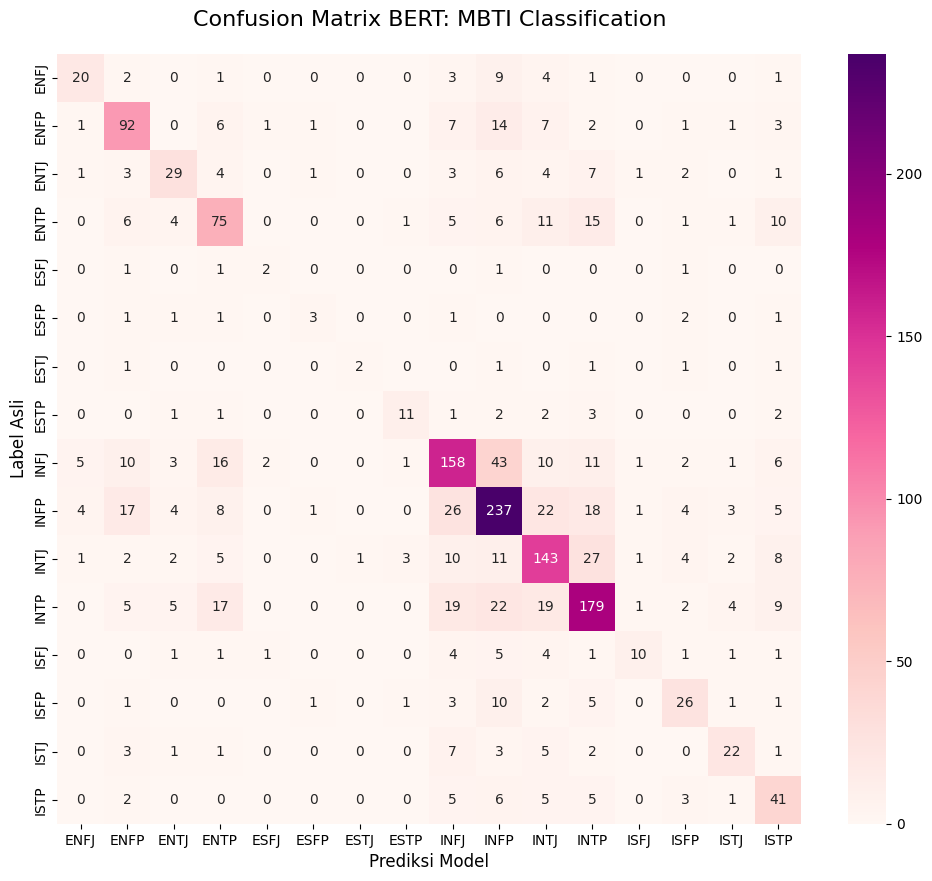

In [35]:
# hitung confusion matrix
cm = confusion_matrix(y_true_bert, y_pred_bert)

# atur ukuran gambar
plt.figure(figsize=(12, 10))

# buat heatmap dengan Seaborn
sns.heatmap(
    cm,
    annot=True,                 # Menampilkan angka di dalam kotak
    fmt='d',                    # Format angka sebagai desimal (integer)
    cmap='RdPu',                # Warna 'Red-Purple' (Pink keunguan) yang elegan
    xticklabels=label_encoder.classes_, # Label MBTI di sumbu X
    yticklabels=label_encoder.classes_, # Label MBTI di sumbu Y
    cbar=True                   # Menampilkan batang panduan warna
)

# tambahkan label dan judul
plt.title('Confusion Matrix BERT: MBTI Classification', fontsize=16, pad=20)
plt.xlabel('Prediksi Model', fontsize=12)
plt.ylabel('Label Asli', fontsize=12)

# tampilkan
plt.show()

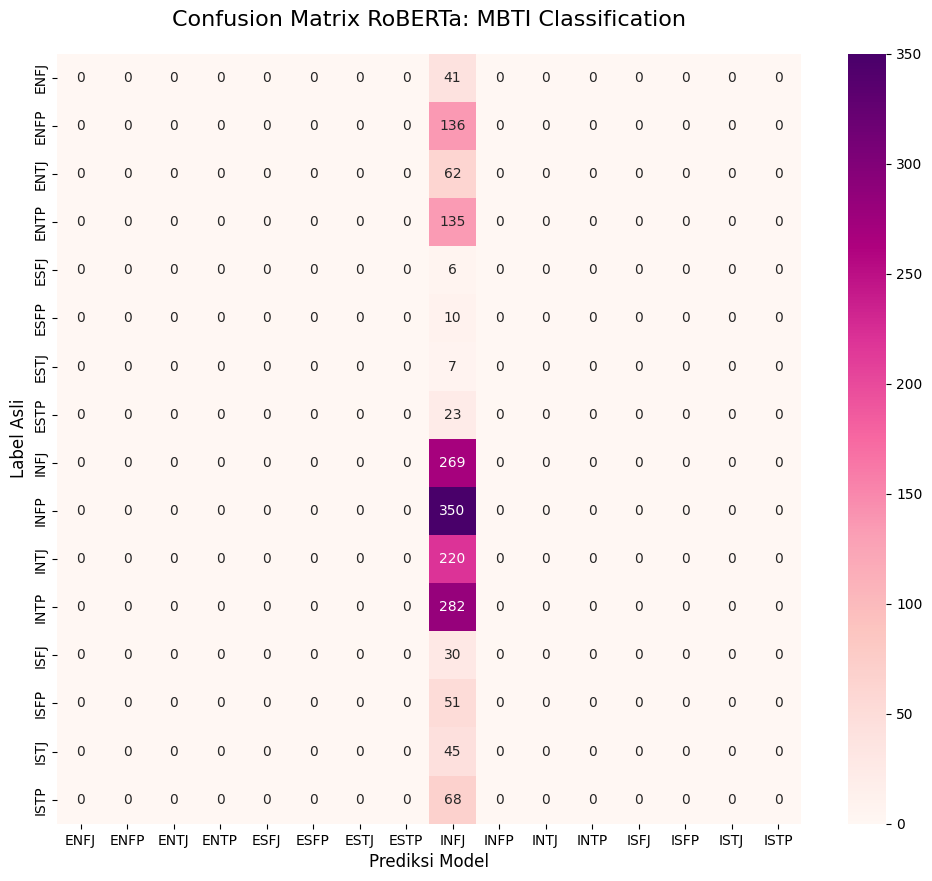

In [36]:
# hitung confusion matrix
cm = confusion_matrix(y_true_roberta, y_pred_roberta)

# atur ukuran gambar
plt.figure(figsize=(12, 10))

# buat heatmap dengan Seaborn
sns.heatmap(
    cm,
    annot=True,                 # Menampilkan angka di dalam kotak
    fmt='d',                    # Format angka sebagai desimal (integer)
    cmap='RdPu',                # Warna 'Red-Purple' (Pink keunguan) yang elegan
    xticklabels=label_encoder.classes_, # Label MBTI (INFP, INFJ, dst) di sumbu X
    yticklabels=label_encoder.classes_, # Label MBTI di sumbu Y
    cbar=True                   # Menampilkan batang panduan warna
)

# tambahkan Label dan Judul
plt.title('Confusion Matrix RoBERTa: MBTI Classification', fontsize=16, pad=20)
plt.xlabel('Prediksi Model', fontsize=12)
plt.ylabel('Label Asli', fontsize=12)

# tampilkan
plt.show()

## Pengujian

In [37]:
# memprediksi MBTI user
def predict_mbti_type(text):
    # tokenisasi, pt = pytorch
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # pindahkan input tensor ke device yang sama dengan model
    with torch.no_grad():               # menonaktifkan perhitungan gradien (hemat memori dan cepat)
        outputs = model_bert(**inputs)
        logits = outputs.logits

    # prediksi model
    predicted_class = torch.argmax(logits, dim=-1).item()
    return predicted_class

# konversi balik ke MBTI
def get_mbti_type(predicted_class):
    return label_encoder.classes_[predicted_class]

In [38]:
# load dataset
dataset_path = "mbti_1.csv"
df = pd.read_csv(dataset_path)

# load fine-tuned model dan tokenizer
model_path_bert = './fine-tuned-model-bert'
model_bert = BertForSequenceClassification.from_pretrained(model_path_bert)
tokenizer = BertTokenizer.from_pretrained(model_path_bert)

# evaluasi model
model_bert.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [39]:
# Fungsi prediksi untuk multiple inputs
def predict_mbti_types(texts):
    """
    texts: list of strings
    returns: list of MBTI types
    """
    # Tokenisasi
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Prediksi logits
    with torch.no_grad():
        outputs = model_bert(**inputs)
        logits = outputs.logits

    # Ambil kelas prediksi
    predicted_classes = torch.argmax(logits, dim=-1).tolist()

    # Konversi ke MBTI type
    mbti_types = [label_encoder.classes_[cls] for cls in predicted_classes]
    return mbti_types

# Contoh input list
multi_mbti_posts = [
    "I love going out and experiencing new things. Weekends are for adventures and meeting new people. Sports, parties, and spontaneous trips make me feel alive. I tend to act on impulse and enjoy challenges that push me out of my comfort zone. Life is about doing, not overthinking.",
    "I enjoy planning for the long term and setting challenging goals. I spend time analyzing patterns in the world and reflecting on ideas. Social events drain me unless they have a clear purpose. I prefer to think strategically rather than react impulsively. Deep conversations are far more rewarding than small talk.",
    "I am full of ideas and love sharing them with others. Meeting new people excites me, and I often feel inspired to start new projects. Exploring possibilities and brainstorming keeps me motivated. Life feels like an adventure that I want to experience creatively.",
    "I enjoy figuring out how things work and fixing them myself. Hands-on activities and practical tasks are what I excel at. When faced with a problem, I analyze it calmly and logically. I value my independence and dislike being micromanaged.",
    "I care deeply about people and their feelings. I often think about how my actions affect others and try to guide them toward growth. I prefer meaningful one-on-one conversations to large social gatherings. Planning and reflecting help me make sense of the world.",
    "I enjoy helping others and making sure everyone feels comfortable. I like social gatherings and traditions. Being attentive to others’ needs and maintaining harmony is very important to me. I feel satisfied when I can make a positive impact in people’s lives.",
    "I love debating ideas and challenging conventional thinking. New possibilities excite me and I often jump into projects with enthusiasm. I enjoy spontaneity and adapting quickly to changes. Creative problem solving keeps me engaged.",
    "I take pride in being reliable and supportive. I notice small details that others might overlook and enjoy helping people quietly. I prefer familiar routines and meaningful connections. Stability and loyalty matter a lot to me.",
    "I enjoy leading projects and making strategic decisions. I like setting ambitious goals and driving teams toward success. I focus on efficiency and results, and I thrive in competitive environments. Planning and organization are my strengths.",
    "I spend a lot of time reflecting on my values and feelings. I enjoy creative expression and imagining new possibilities. Meaningful connections with people are very important to me. I often seek harmony and authenticity in everything I do.",
]


# Prediksi
for user_inputs in multi_mbti_posts:
    predicted_mbti_list = predict_mbti_types(user_inputs)
    for text, mbti in zip(user_inputs, predicted_mbti_list):
        # print(f"Post: {text[:60]}...")  # potong teks panjang
        print(f"Predicted MBTI Type: {mbti}\n")


Predicted MBTI Type: INFP

Predicted MBTI Type: INTP

Predicted MBTI Type: INFJ

Predicted MBTI Type: ISTP

Predicted MBTI Type: INFJ

Predicted MBTI Type: INFP

Predicted MBTI Type: INFJ

Predicted MBTI Type: INFJ

Predicted MBTI Type: ISTP

Predicted MBTI Type: INFJ



## Referensi

**Paper / Jurnal**
- Mahdavi, A. et al. (2023). *Process of Fine-tune BERT model by transforming the feature space Z Layer*. [Link](https://www.researchgate.net/profile/Atefeh-Mahdavi-5/publication/373518572/figure/fig1/AS:11431281184804636@1693451040732/Process-of-Fine-tune-BERT-model-by-transforming-the-feature-space-Z-Layer-and-enhancing.ppm)
- Diva Portal. (2023). *Full Text Research on Transformer Models*. [Link](https://www.diva-portal.org/smash/get/diva2:1970734/FULLTEXT01.pdf)
- ECUST Journal. *Supplementary Research on NLP & Transformers*. [Link](https://journal.ecust.edu.cn/en/supplement/97a7d394-ed98-4401-b23d-b4caf43437f6)

**Blog / Artikel**
- DSStream. (2023). *RoBERTa vs BERT: Exploring the Evolution of Transformer Models*. [Link](https://www.dsstream.com/post/roberta-vs-bert-exploring-the-evolution-of-transformer-models)
- McCormick, C. (2019). *BERT Fine-Tuning Guide*. [Link](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)
- Achimoraites. (2022). *Fine-tuning RoBERTa for Topic Classification*. [Link](https://achimoraites.medium.com/fine-tuning-roberta-for-topic-classification-with-hugging-face-transformers-and-datasets-library-c6f8432d0820)

**Dataset**
- Tonylica. (2022). *MBTI: A NLP Model Approach*. [Kaggle](https://www.kaggle.com/code/tonylica/mbti-a-nlp-model-approach)

**Video / Tutorial**
- YouTube. (2023). *Fine-Tuning BERT for NLP*. [Link](https://www.youtube.com/watch?v=GDN649X_acE)
- YouTube. (2023). *RoBERTa vs BERT Explanation*. [Link](https://youtu.be/xI0HHN5XKDo?si=7n2nUbJJ1-mfNzTv)
- YouTube. (2023). *Transformers for NLP Overview*. [Link](https://youtu.be/4QHg8Ix8WWQ?si=vggzGHfhEkjU4_lu)

**Gambar / Visualisasi**
- Bukittinggi MBTI Types. [Link](https://cdn.rri.co.id/berita/Bukittinggi/o/1719477122444-mbti-typesjpg-20220217032149/sd5zza9sghwmsis.jpeg)
- BERT Fine-Tuning Process Diagram. [Link](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRbq390DtGQyAS07weYKglje8JXzHltcxJYrQ&s)
